# BG1 model with thalamo-cortical loop

## 2016-09-06

This adds a TC loop to the bg1 model.

The first code block is some mean-firing rate visualisation code.

In [31]:
# Visualisation of mean firing rates from bg1 simulation, with and without sigmoid.
import numpy as np

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Graph the data. Sub-called by vis_data
def graph_data (bin_edges1, fr_sigI, logfile):
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,8))

    plt.plot (bin_edges1[0:-1],fr_sigI[0,:], '--', color='r', marker='o', label='Ch0', linewidth=3)
    plt.plot (bin_edges1[0:-1],fr_sigI[1,:], '--',  color='b', marker='o', label='Ch1', linewidth=3)
    plt.plot (bin_edges1[0:-1],fr_sigI[2,:], '--',  color='g', marker='o', label='Ch2', linewidth=3)

    plt.legend(loc='best',fontsize=14)

    plt.xlabel('t (ms)',fontsize=24);
    
    from matplotlib import rc
    plt.ylabel('mean neuronal firing rate (s$^{-1}$)',fontsize=24);
    plt.tick_params(axis='x', labelsize=24, pad=10)
    plt.tick_params(axis='y', labelsize=24, pad=10)
    
    plt.title(logfile)

    graphdir = '/home/seb/izhibg/GPR_Izhikevich/labbook/'

    filename = logfile.replace(' ','_')
    plt.savefig('{0}{1}.svg'.format(graphdir, filename))
    
    plt.show()

# Read & precompute the data. Sub-called by vis_data and compute_decision
def compute_data (logdir1, logfile):
    logpath = logdir1 + logfile
    sl_sigI = np.genfromtxt (logpath, delimiter=',')
    ch1idx_sigI  = (sl_sigI[:,1] < 20)
    ch2idx_sigI  = (sl_sigI[:,1] < 40) & (sl_sigI[:,1] > 19)
    ch3idx_sigI  = (sl_sigI[:,1] < 60) & (sl_sigI[:,1] > 39)

    # Give our histograms 20 bins.
    numbins = 40

    ch1fr, bin_edges1 = np.histogram (sl_sigI[ch1idx_sigI,0], numbins)
    ch2fr, bin_edges2 = np.histogram (sl_sigI[ch2idx_sigI,0], numbins)
    ch3fr, bin_edges3 = np.histogram (sl_sigI[ch3idx_sigI,0], numbins)
    fr_sigI = np.vstack((ch1fr,ch2fr,ch3fr))
    allfr_sigI, bin_edgesall = np.histogram (sl_sigI[:,0], numbins)

    # There are 20 neurons per channel in this model, 60 total
    neuronsPerChan = 20
    num_channels_used = 3 # We only take data from first 3 channels!
    neuronsPerInvestigation = neuronsPerChan * num_channels_used

    simlength_ms = 4000    
    
    # Scale the firing rates
    bintime = simlength_ms / numbins;
    fr_sigI  = (fr_sigI) * 1000 / (bintime * neuronsPerChan)
    allfr_sigI = (allfr_sigI * 1000) / (bintime * neuronsPerInvestigation)

    return bin_edges1, fr_sigI
    
# Visualise the given logfile (the log of a single population) for the two
# simulation outputs in logdir1 and logdir2. Assumptions about what kind of
# data is in logdir1 and logdir2 are made.
def vis_data (logdir1, logfile):
    bin_edges1, fr_sigI = compute_data (logdir1, logfile)
    graph_data (bin_edges1, fr_sigI, logfile)

## end visualisation function

## Steady state model without closed loop

This is experiment 7 in the bg1tc model. It allows me to look at the model behaviour in the absence of a connection from SNr/GPi to Thalamus. This means that I can tune up the TC loop on its own, without the BG affecting it.

Response of BG1TC model to steady state input.


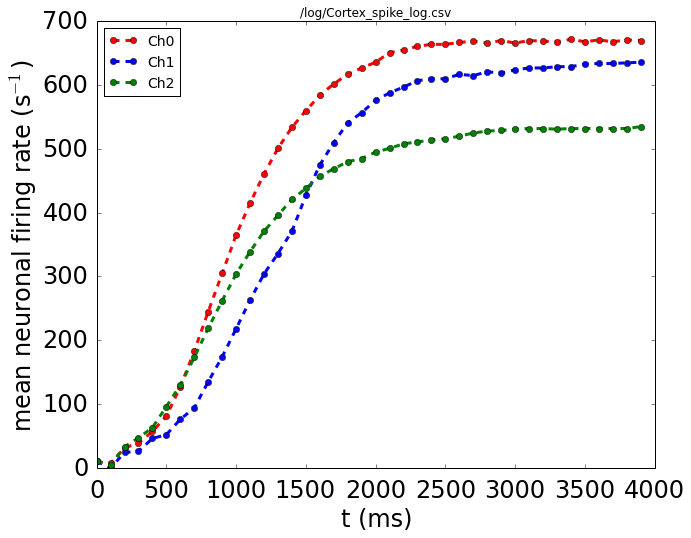

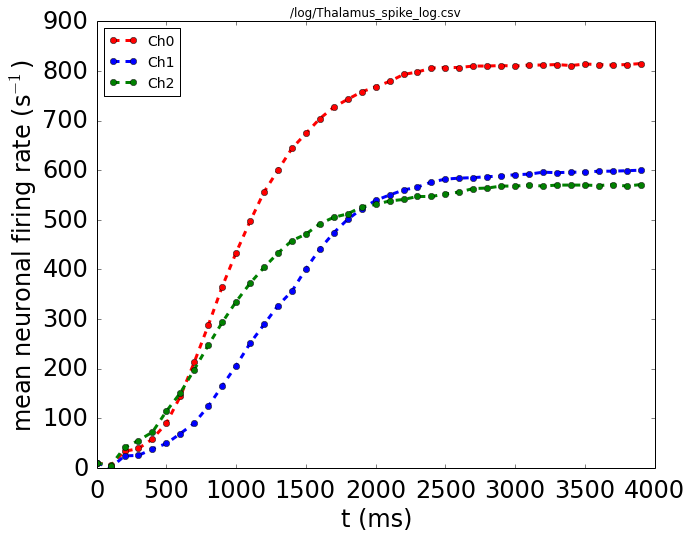

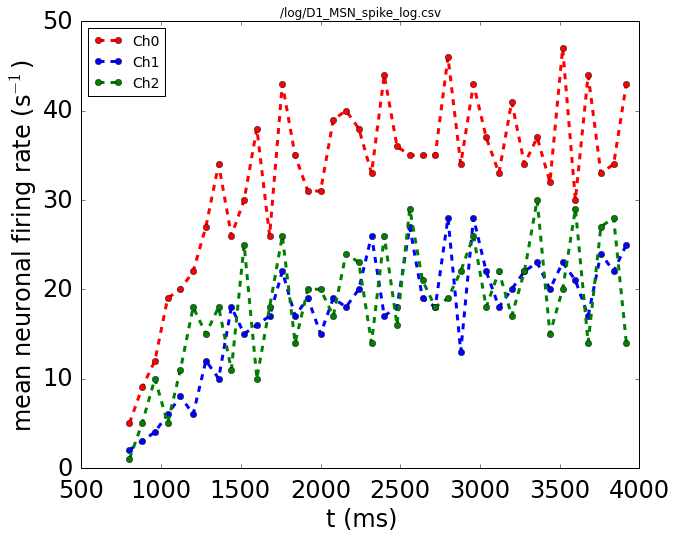

In [46]:
# Set to 0 if you're messing with the program and you already computed the simulation:
require_recompute = 1;

# Where is the data going to end up?
logdir1 = '/home/seb/tmp/impulse'

# Import update_bg1_model_xml.py
import sys
sys.path.append("../analysis")
import update_bg1_model_xml as bg1update

print ('Response of BG1TC model to steady state input.')

# Where's the source model?
modeldir = '/home/seb/izhibg/GPR_Izhikevich/bg1tc'
expt = 7 # 7 is the steady state with no SNr->Thal connection

# Run the model
import os
spineml2brahms ='/home/seb/src/SpineML_2_BRAHMS'
spinemlcmd = '/bin/bash -c "pushd '+spineml2brahms+' && '+\
             'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m '+modeldir+' -e'+\
             `expt` + ' -o ' + `logdir1` + ' ; popd"';
if require_recompute:
    os.system(spinemlcmd);

# Call the visualisation for populations of interest:
logfile = '/log/Cortex_spike_log.csv'
vis_data (logdir1, logfile)
logfile = '/log/Thalamus_spike_log.csv'
vis_data (logdir1, logfile)
logfile = '/log/D1_MSN_spike_log.csv'
vis_data (logdir1, logfile)


** 2016-09-06 **

I've got a problem with this TC loop, which is that given stochastic connections within each of the three channels, I have each of the TC loop channels having different responses - that is channel 3 stabilises at 500 spikes/s, but ch2 is only about 280 and ch3 is less still. If I re-generate the connections from Thalamus to cortex or vice versa, then the ordering changes, so it's all about the luck of the draw - if a channel gets regenerated with a few more connections, then it may produce a higher firing rate. This is not what I want; I want the channels to produce similar rates for background input.

A possible solution is to have 3 separate cortex populations, and tweak the weights from thalamus to the individual populations so that the firing rates stabilise to a similar rate. Simpler would be to have 3 different backgrounds that compensate for the wiring.

I found one problem was that I had different weights in the 2 synapses for the spike input -> Cortex connections.

Once that was fixed, I was surprised to find that I had to turn one of the channels input spike rate down to 3 compared with 5 for the other two channels. This means that Ch1 rises slower than the other two, but reaches the same mean equilibrium value. Re-generating the connectivity can change which channel is strongest (with all inputs set to 5). So I think to use a TC loop like this, I will need some sort of adaptation to get the channels to run up to the same equilibrium firing for background operation.

I think I'll try to fix this by changing weights from Spikes to Cortex.